# word2vec creation.
In the following code, the class 'data_creation_word2vec' is able to to create a word2vec embedding matrix as the input layer for the deep learning architectures. Word2vec types can be from "Twitter', "Google', or generating randomly. Training and test dataset can be chosen from 2-class or 3-class. 

In [1]:
import numpy as np
import os
import logging
from gensim.models.keyedvectors import KeyedVectors
import warnings
import csv
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import random
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# cleaning process to remove any punctuation, parentheses, question marks. This leaves only alphanumeric characters.
remove_special_chars = re.compile("[^A-Za-z0-9 ]+")

class data_creation_word2vec():
    @staticmethod
    def clean(sentence):
        return re.sub(remove_special_chars, "", sentence.lower())

    def __init__(self, filename_train, filename_test, word2vec_type, classdataset):
        self.classdataset = classdataset
        self.word2vec_type = word2vec_type  # 'Google' or 'Twitter', 'random'
        # Parse train data
        filename = '../LSTM-CNN code/' + filename_train
        with open(filename, 'r', encoding='utf-8', newline='') as f:
            reader = csv.reader(f)
            training_tweets = []
            for tweet in reader:
                tweet[2] = data_creation_word2vec.clean(tweet[2])
                training_tweets.append(tweet)
        self.training_tweets = training_tweets
        # Parse test data
        filename = '../LSTM-CNN code/' + filename_test
        with open(filename, 'r', encoding='utf-8', newline='') as f:
            reader = csv.reader(f)
            test_tweets = []
            for tweet in reader:
                tweet[2] = data_creation_word2vec.clean(tweet[2])
                test_tweets.append(tweet)
        self.test_tweets = test_tweets

        if word2vec_type == 'Twitter':
            # word2vec model from twitter based on 400 m tweets. Final results is for 3039345 m words with
            # 400-dimension vector
            self.Word2Vec_model = KeyedVectors.load_word2vec_format('word2vec_twitter_model.bin', binary=True,
                                                                    encoding='latin-1')
        if word2vec_type == 'Google' or word2vec_type == 'random':
            # word2vec model from pre-trained Google model with 1 m words and 300-dimension vector
            self.Word2Vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

    def data_creation(self):
        if self.word2vec_type == "Twitter" or self.word2vec_type == 'Google':
            vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(1, 1), analyzer=u'word')
            analyze = vectorizer.build_analyzer()
            # Create Train_Y (i.e., labels)
            Train_Y = [int(tweet[0]) for tweet in self.training_tweets]

            # Create (Lxd) word embedding matrix corresponding to each tweet. L: number of words in tweet,
            # d: word vector dimension
            d = self.Word2Vec_model.vector_size
            if d == 300:  # means we are using Google word2vec
                L = 12  # 90 percentile value of number of words in a tweet based on Google
            else:
                L = 13  # 90 percentile value of number of words in a tweet based on Twitter

            Train_X = np.zeros((len(self.training_tweets), L, d), dtype=np.float32)
            for i in range(len(self.training_tweets)):
                words_seq = analyze(self.training_tweets[i][2])
                index = 0
                for word in words_seq:
                    if index < L:
                        try:
                            Train_X[i, index, :] = self.Word2Vec_model[word]
                            index += 1
                        except KeyError:
                            pass
                    else:
                        break


            Test_Y_ori = [int(tweet[0]) for tweet in self.test_tweets]
            Test_X = np.zeros((len(self.test_tweets), L, d), dtype=np.float32)
            for i in range(len(self.test_tweets)):
                words_seq = analyze(self.test_tweets[i][2])
                index = 0
                for word in words_seq:
                    if index < L:
                        try:
                            Test_X[i, index, :] = self.Word2Vec_model[word]
                            index += 1
                        except KeyError:
                            pass
                    else:
                        break
            filename = '1_Word2Vec_' + self.word2vec_type + '_' + self.classdataset + '.pickle'
            with open(filename, 'wb') as f:
                pickle.dump([Train_X, Test_X, Train_Y, Test_Y_ori], f)
            print("{} word2vec matrix has been created as the input layer".format(self.word2vec_type))

        elif self.word2vec_type == 'random':
            # Create randomized word embedding matrix for test and train data
            L = 12  # the same as Google
            d = 300  # the same as Google
            Train_X = np.zeros((len(self.training_tweets), L, d), dtype=np.float32)
            max_val = np.amax(self.Word2Vec_model.syn0)
            min_val = np.amin(self.Word2Vec_model.syn0)
            for i in range(len(self.training_tweets)):
                Train_X[i, :, :] = min_val + (max_val - min_val) * np.random.rand(L, d)

            Test_X = np.zeros((len(self.test_tweets), L, d), dtype=np.float32)
            for i in range(len(self.test_tweets)):
                Test_X[i, :, :] = min_val + (max_val - min_val) * np.random.rand(L, d)

            Test_Y_ori = [int(tweet[0]) for tweet in self.test_tweets]
            Train_Y = [int(tweet[0]) for tweet in self.training_tweets]
            filename = '1_Word2Vec_' + self.word2vec_type + '_' + self.classdataset + '.pickle'
            with open(filename, 'wb') as f:
                pickle.dump([Train_X, Test_X, Train_Y, Test_Y_ori], f)
            
            print("{} word2vec matrix has been created as the input layer".format(self.word2vec_type))

if __name__ == '__main__':
    word2vec = data_creation_word2vec(filename_train='1_TrainingSet_2Class.csv', filename_test='1_TestSet_2Class.csv',
                                           word2vec_type='Google', classdataset='2class')

    word2vec.data_creation()


c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\gensim-2.2.0-py3.5-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
2017-12-10 10:25:23,052 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2017-12-10 10:26:34,949 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


Google word2vec matrix has been created as the input layer


# Example: CNN-based model with Twitter word2vec model for 3-class dataset

In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Reshape
import pickle
from keras.optimizers import Adam
import csv
from sklearn.metrics import confusion_matrix
import time
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
start_time = time.clock()

# Parse data
filename = '../LSTM-CNN code/1_Word2Vec_Twitter_3class.pickle'
with open(filename, mode='rb') as f:
    Train_X, Test_X, Train_Y, Test_Y_ori = pickle.load(f, encoding='latin1')  # Also can use the encoding 'iso-8859-1'

# Construct CNN model.
NoClass = len(list(set((Train_Y))))

Train_Y = keras.utils.to_categorical(Train_Y, num_classes=NoClass)
Test_Y = keras.utils.to_categorical(Test_Y_ori, num_classes=NoClass)

L = len(Train_X[0, :, 0])
d = len(Train_X[0, 0, :])

# Model and Compile
model = Sequential()
model.add(Reshape((L, d, 1), input_shape=(L, d)))

model.add(Conv2D(100, (2, d), strides=(1, 1), padding='valid', activation='relu', use_bias=True))

# model.add(Conv2D(100, (2, 1), strides=(1, 1), padding='valid', activation='relu', use_bias=True))

output = model.output_shape
model.add(MaxPooling2D(pool_size=(output[1], output[2])))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(NoClass, activation='softmax'))

# model.add(Dense(NoClass, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
# Optimizer and loss function
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================================================================================
# Check point and save the best model
filepath = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(Train_X, Train_Y, epochs=20, batch_size=64, shuffle=False,
                            validation_data=(Test_X, Test_Y), callbacks=callbacks_list)

# Print the maximum acc_val and its corresponding epoch
index = np.argmax(hist.history['val_acc'])
print('The optimal epoch size: {}, The value of high accuracy {}'.format(hist.epoch[index], np.max(hist.history['val_acc'])))
print('\n')
print('Computation Time', time.clock() - start_time, "seconds")
print('\n')

# Save the history accuracy results.
with open('Accuracy-History-CNN-2class.pickle', 'wb') as f:
    pickle.dump([hist.epoch, hist.history['acc'], hist.history['val_acc']], f)

# =============================================================================================================
# load weights, predict based on the best model, compute accuracy, precision, recall, f-score, confusion matrix.
model.load_weights("weights.best2.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Computer confusion matrix, precision, recall.
pred = model.predict(Test_X, batch_size=64)
y_pred = np.argmax(pred, axis=1)
Test_Y_ori = [int(item) for item in Test_Y_ori]
print('Test Accuracy %: ', len(np.where(y_pred == np.array(Test_Y_ori))[0])/len(Test_Y_ori) * 100)
print('\n')
print('Confusin matrix: ', confusion_matrix(Test_Y_ori, y_pred))
print(classification_report(Test_Y_ori, y_pred, digits=3))
# =====================================================================================================


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2017-12-10 11:01:51,431 : WARNING : From c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:1064: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2017-12-10 11:01:51,537 : WARNING : From c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:2578: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2017-12-10 11:01:51,594 : WARNING : From c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:1153: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Train on 40942 samples, validate on 10236 samples
Epoch 1/20
40942/40942 [==============================] - 14s - loss: 0.1770 - acc: 0.9404 - val_loss: 0.1016 - val_acc: 0.9654
Epoch 2/20
40942/40942 [==============================] - 8s - loss: 0.1133 - acc: 0.9626 - val_loss: 0.0955 - val_acc: 0.9666
Epoch 3/20
40942/40942 [==============================] - 8s - loss: 0.0966 - acc: 0.9683 - val_loss: 0.0967 - val_acc: 0.9672
Epoch 4/20
40942/40942 [==============================] - 8s - loss: 0.0843 - acc: 0.9722 - val_loss: 0.0944 - val_acc: 0.9692
Epoch 5/20
40942/40942 [==============================] - 8s - loss: 0.0810 - acc: 0.9737 - val_loss: 0.0962 - val_acc: 0.9682
Epoch 6/20
40942/40942 [==============================] - 9s - loss: 0.0735 - acc: 0.9763 - val_loss: 0.0918 - val_acc: 0.9708
Epoch 7/20
40942/40942 [==============================] - 8s - loss: 0.0677 - acc: 0.9775 - val_loss: 0.0927 - val_acc: 0.9695
Epoch 8/20
40942/40942 [==============================] - 8s

# Example: LSTM-based model with Google word2vec model for 2-class dataset

In [3]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
import pickle
from keras.optimizers import SGD, Adam
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
from keras.layers import LSTM, GRU
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

start_time = time.clock()

# parse data
filename = '../LSTM-CNN code/1_Word2Vec_Google_2class.pickle'
with open(filename, mode='rb') as f:
    Train_X, Test_X, Train_Y, Test_Y_ori = pickle.load(f, encoding='latin1')  # Also can use the encoding 'iso-8859-1'

# Construct and compile the LSTM model
NoClass = len(list(set(Train_Y)))

Train_Y = keras.utils.to_categorical(Train_Y, num_classes=NoClass)
Test_Y = keras.utils.to_categorical(Test_Y_ori, num_classes=NoClass)

L = len(Train_X[0, :, 0])
d = len(Train_X[0, 0, :])

model = Sequential()
# model.add(GRU(32, return_sequences=False, input_shape=(L, d)))
model.add(LSTM(50, return_sequences=False, input_shape=(L, d)))  # returns a sequence of vectors with dimension of units
#model.add(LSTM(32))
model.add(Dropout(.50))

model.add(Dense(NoClass, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================================================================================
# Training, check point and save the best model
filepath = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(Train_X, Train_Y, epochs=20, batch_size=64, shuffle=False,
                            validation_data=(Test_X, Test_Y), callbacks=callbacks_list)

# Print the maximum acc_val and its corresponding epoch
index = np.argmax(hist.history['val_acc'])
print('\n')
print('The optimal epoch size: {}, The value of high accuracy {}'.format(hist.epoch[index], np.max(hist.history['val_acc'])))
print('\n')
print('Computation Time', time.clock() - start_time, "seconds")
print('\n')

# =============================================================================================================
# load weights, predict based on the best model, compute accuracy, precision, recall, f-score, confusion matrix.
model.load_weights("weights.best2.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Computer confusion matrix, precision, recall.
pred = model.predict(Test_X, batch_size=64)
y_pred = np.argmax(pred, axis=1)
Test_Y_ori = [int(item) for item in Test_Y_ori]
print('Test Accuracy %: ', len(np.where(y_pred == np.array(Test_Y_ori))[0])/len(Test_Y_ori) * 100)
print('\n')
print('Confusin matrix: ', confusion_matrix(Test_Y_ori, y_pred))
print('\n')
print(classification_report(Test_Y_ori, y_pred, digits=3))
# =====================================================================================================


Train on 40879 samples, validate on 10221 samples
Epoch 1/20
40879/40879 [==============================] - 26s - loss: 0.1021 - acc: 0.9726 - val_loss: 0.0685 - val_acc: 0.9796
Epoch 2/20
40879/40879 [==============================] - 24s - loss: 0.0566 - acc: 0.9832 - val_loss: 0.0615 - val_acc: 0.9809
Epoch 3/20
40879/40879 [==============================] - 24s - loss: 0.0496 - acc: 0.9848 - val_loss: 0.0580 - val_acc: 0.9813
Epoch 4/20
40879/40879 [==============================] - 24s - loss: 0.0453 - acc: 0.9864 - val_loss: 0.0563 - val_acc: 0.9819
Epoch 5/20
40879/40879 [==============================] - 25s - loss: 0.0409 - acc: 0.9876 - val_loss: 0.0552 - val_acc: 0.9823
Epoch 6/20
40879/40879 [==============================] - 26s - loss: 0.0361 - acc: 0.9891 - val_loss: 0.0578 - val_acc: 0.9830
Epoch 7/20
40879/40879 [==============================] - 26s - loss: 0.0326 - acc: 0.9900 - val_loss: 0.0588 - val_acc: 0.9825
Epoch 8/20
40879/40879 [==============================

# Example: CNN+LSTM model with Google word2vec model for 2-class dataset

In [4]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, Lambda, Reshape
import pickle
from keras.optimizers import Adam
import os
from sklearn.metrics import confusion_matrix
import time
from keras.layers import LSTM
from keras import regularizers
from keras.backend import mean
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

start_time = time.clock()

# Parse data
filename = '../LSTM-CNN code/1_Word2Vec_Twitter_3class.pickle'
with open(filename, mode='rb') as f:
    Train_X, Test_X, Train_Y, Test_Y_ori = pickle.load(f, encoding='latin1')  # Also can use the encoding 'iso-8859-1'

# Construct and compile the LSTM model
NoClass = len(list(set(Train_Y)))

Train_Y = keras.utils.to_categorical(Train_Y, num_classes=NoClass)
Test_Y = keras.utils.to_categorical(Test_Y_ori, num_classes=NoClass)

L = len(Train_X[0, :, 0])
d = len(Train_X[0, 0, :])

model = Sequential()
model.add(Reshape((L, d, 1), input_shape=(L, d)))
model.add(Conv2D(100, (2, d), strides=(1, 1), padding='valid', activation='relu', use_bias=True))
output = model.output_shape
model.add(Reshape((output[1], output[3])))
model.add(Dropout(.25))
model.add(LSTM(100, return_sequences=False, activation='tanh', recurrent_activation='hard_sigmoid'))
model.add(Dropout(.50))
model.add(Dense(NoClass, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================================================================================
# Training, check point and save the best model
filepath = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(Train_X, Train_Y, epochs=20, batch_size=64, shuffle=False,
                            validation_data=(Test_X, Test_Y), callbacks=callbacks_list)

# Print the maximum acc_val and its corresponding epoch
index = np.argmax(hist.history['val_acc'])
print('\n')
print('The optimal epoch size: {}, The value of high accuracy {}'.format(hist.epoch[index], np.max(hist.history['val_acc'])))
print('\n')
print('Computation Time', time.clock() - start_time, "seconds")
print('\n')

# =============================================================================================================
# load weights, predict based on the best model, compute accuracy, precision, recall, f-score, confusion matrix.
model.load_weights("weights.best2.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Computer confusion matrix, precision, recall.
pred = model.predict(Test_X, batch_size=64)
y_pred = np.argmax(pred, axis=1)
Test_Y_ori = [int(item) for item in Test_Y_ori]
print('Test Accuracy %: ', len(np.where(y_pred == np.array(Test_Y_ori))[0])/len(Test_Y_ori) * 100)
print('\n')
print('Confusin matrix: ', confusion_matrix(Test_Y_ori, y_pred))
print('\n')
print(classification_report(Test_Y_ori, y_pred, digits=3))
# =====================================================================================================


Train on 40942 samples, validate on 10236 samples
Epoch 1/20
40942/40942 [==============================] - 67s - loss: 0.2455 - acc: 0.9167 - val_loss: 0.1353 - val_acc: 0.9596
Epoch 2/20
40942/40942 [==============================] - 24s - loss: 0.1144 - acc: 0.9671 - val_loss: 0.1110 - val_acc: 0.9658
Epoch 3/20
40942/40942 [==============================] - 24s - loss: 0.0972 - acc: 0.9712 - val_loss: 0.1115 - val_acc: 0.9691
Epoch 4/20
40942/40942 [==============================] - 23s - loss: 0.0855 - acc: 0.9748 - val_loss: 0.1037 - val_acc: 0.9689
Epoch 5/20
40942/40942 [==============================] - 23s - loss: 0.0775 - acc: 0.9777 - val_loss: 0.1034 - val_acc: 0.9712
Epoch 6/20
40942/40942 [==============================] - 24s - loss: 0.0706 - acc: 0.9805 - val_loss: 0.1151 - val_acc: 0.9669
Epoch 7/20
40942/40942 [==============================] - 23s - loss: 0.0651 - acc: 0.9822 - val_loss: 0.1135 - val_acc: 0.9678
Epoch 8/20
40942/40942 [==============================

# Example: CNN+LSTM model with random word2vec model for 3-class dataset

In [8]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, Lambda, Reshape
import pickle
from keras.optimizers import Adam
import os
from sklearn.metrics import confusion_matrix
import time
from keras.layers import LSTM
from keras import regularizers
from keras.backend import mean
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

start_time = time.clock()

# Parse data
filename = '../LSTM-CNN code/1_Word2Vec_random_3class.pickle'
with open(filename, mode='rb') as f:
    Train_X, Test_X, Train_Y, Test_Y_ori = pickle.load(f, encoding='latin1')  # Also can use the encoding 'iso-8859-1'

# Construct and compile the LSTM model
NoClass = len(list(set(Train_Y)))

Train_Y = keras.utils.to_categorical(Train_Y, num_classes=NoClass)
Test_Y = keras.utils.to_categorical(Test_Y_ori, num_classes=NoClass)

L = len(Train_X[0, :, 0])
d = len(Train_X[0, 0, :])

model = Sequential()
model.add(Reshape((L, d, 1), input_shape=(L, d)))
model.add(Conv2D(100, (2, d), strides=(1, 1), padding='valid', activation='relu', use_bias=True))
output = model.output_shape
model.add(Reshape((output[1], output[3])))
model.add(Dropout(.25))
model.add(LSTM(100, return_sequences=False, activation='tanh', recurrent_activation='hard_sigmoid'))
model.add(Dropout(.50))
model.add(Dense(NoClass, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================================================================================
# Training, check point and save the best model
filepath = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(Train_X, Train_Y, epochs=20, batch_size=64, shuffle=False,
                            validation_data=(Test_X, Test_Y), callbacks=callbacks_list)

# Print the maximum acc_val and its corresponding epoch
index = np.argmax(hist.history['val_acc'])
print('\n')
print('The optimal epoch size: {}, The value of high accuracy {}'.format(hist.epoch[index], np.max(hist.history['val_acc'])))
print('\n')
print('Computation Time', time.clock() - start_time, "seconds")
print('\n')

# =============================================================================================================
# load weights, predict based on the best model, compute accuracy, precision, recall, f-score, confusion matrix.
model.load_weights("weights.best2.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Computer confusion matrix, precision, recall.
pred = model.predict(Test_X, batch_size=64)
y_pred = np.argmax(pred, axis=1)
Test_Y_ori = [int(item) for item in Test_Y_ori]
print('Test Accuracy %: ', len(np.where(y_pred == np.array(Test_Y_ori))[0])/len(Test_Y_ori) * 100)
print('\n')
print('Confusin matrix: ', confusion_matrix(Test_Y_ori, y_pred))
print('\n')
print(classification_report(Test_Y_ori, y_pred, digits=3))
# =====================================================================================================


Train on 40942 samples, validate on 10236 samples
Epoch 1/20
40942/40942 [==============================] - 26s - loss: 1.0315 - acc: 0.4980 - val_loss: 1.0097 - val_acc: 0.5002
Epoch 2/20
40942/40942 [==============================] - 23s - loss: 1.0052 - acc: 0.5003 - val_loss: 1.0100 - val_acc: 0.5002
Epoch 3/20
40942/40942 [==============================] - 23s - loss: 0.9878 - acc: 0.5083 - val_loss: 1.0212 - val_acc: 0.4827
Epoch 4/20
40942/40942 [==============================] - 24s - loss: 0.9537 - acc: 0.5306 - val_loss: 1.0453 - val_acc: 0.4679
Epoch 5/20
40942/40942 [==============================] - 23s - loss: 0.9050 - acc: 0.5683 - val_loss: 1.0699 - val_acc: 0.4501
Epoch 6/20
40942/40942 [==============================] - 23s - loss: 0.8475 - acc: 0.6118 - val_loss: 1.1076 - val_acc: 0.4407
Epoch 7/20
40942/40942 [==============================] - 22s - loss: 0.7940 - acc: 0.6464 - val_loss: 1.1489 - val_acc: 0.4150
Epoch 8/20
40942/40942 [==============================

c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Distribution of number of words per tweet for both Google and Twitter word2vec models. 

2017-12-10 11:58:11,626 : INFO : loading projection weights from word2vec_twitter_model.bin
2017-12-10 11:59:14,750 : INFO : loaded (3039345, 400) matrix from word2vec_twitter_model.bin
2017-12-10 11:59:20,914 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2017-12-10 12:00:09,791 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


Mean of number of words for Google is 8.480246581374299 and Twitter is 8.82117957875682: 
Median of number of words for Google is 8.0 and Twitter is 9.0: 
90 quantile of number of words for Google is 12.0 and Twitter is 13.0: 
Max of number of words for Google is 20 and Twitter is 21: 
Min of number of words for Google is 0 and Twitter is 0: 
Average number of missing words:  1.0


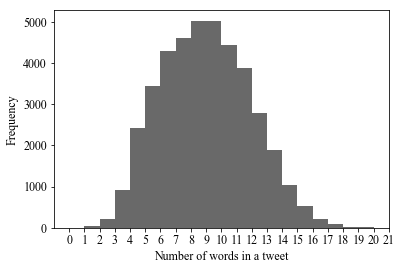

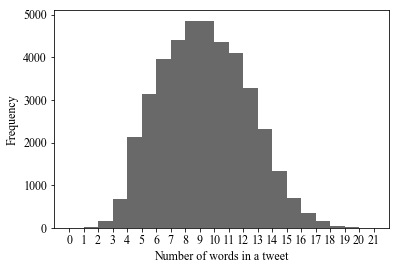

In [6]:
import numpy as np
import csv
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
%matplotlib inline

# Parse data. In this case there is no difference between 2-class and 3-class dataset
filename = '../LSTM-CNN code/1_TrainingSet_2Class.csv'
with open(filename, 'r', encoding='utf-8', newline='') as f:
    def clean(sentence):
        # cleaning process to remove any punctuation, parentheses, question marks. This leaves only alphanumeric characters.
        remove_special_chars = re.compile("[^A-Za-z0-9 ]+")
        return re.sub(remove_special_chars, "", sentence.lower())
    reader = csv.reader(f)
    training_tweets = []
    for tweet in reader:
        tweet[2] = clean(tweet[2])
        training_tweets.append(tweet)

# Find the distribution of number of words in tweets
vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(1, 1), analyzer=u'word')
analyze = vectorizer.build_analyzer()

# word2vec model from twitter based on 400 m tweets. Final results is for 3039345 m words with 400-dimension vector
Word2Vec_model_T = KeyedVectors.load_word2vec_format('word2vec_twitter_model.bin', binary=True, encoding='latin-1')
# word2vec model from pre-trained Google model with 1 m words and 300-dimension vector
Word2Vec_model_G = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

numberofwords_T = []  # for twitter
numberofwords_G = []  # for Google
for tweet in training_tweets:
    words_seq = analyze(tweet[2])
    count = 0
    for word in words_seq:
        try:
            a = Word2Vec_model_T[word]
            count += 1
        except KeyError:
            pass
    numberofwords_T.append(count)

for tweet in training_tweets:
    words_seq = analyze(tweet[2])
    count = 0
    for word in words_seq:
        try:
            a = Word2Vec_model_G[word]
            count += 1
        except KeyError:
            pass
    numberofwords_G.append(count)
# Histogram of number of words per tweet
labels = [['Google_word2vec', numberofwords_G], ['Twitter_word2vec', numberofwords_T]]
for i, wor2vec in enumerate(labels):
    plt.figure(i)
    plt.rcParams['font.family'] = ['serif']  # default is sans-serif
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['font.size'] = 12
    bin = np.linspace(np.min(wor2vec[1]), np.max(wor2vec[1]), np.max(wor2vec[1]) - np.min(wor2vec[1]) + 1)
    plt.hist(wor2vec[1], bins=bin, histtype='bar', color='dimgray')
    #plt.hist(numberofwords_G, bins=np.linspace(0, 22, 23), histtype='step', color='r', label='Google word2vec')
    #plt.legend(prop={'size': 10})
    plt.xticks(np.arange(0, max(max(numberofwords_G), max(numberofwords_T)) + 1, 1.0))
    plt.ylabel('Frequency')
    plt.xlabel('Number of words in a tweet')
    filename = 'Histogram_' + wor2vec[0] +'.png'
    plt.savefig(filename, dpi=1200)


# Summary statistics on number of words in each tweet.
print('Mean of number of words for Google is {} and Twitter is {}: '.
      format(np.mean(numberofwords_G), np.mean(numberofwords_T)))
print('Median of number of words for Google is {} and Twitter is {}: '.
      format(np.median(numberofwords_G), np.median(numberofwords_T)))
print('90 quantile of number of words for Google is {} and Twitter is {}: '.
      format(np.percentile(numberofwords_G, 90), np.percentile(numberofwords_T, 90)))
print('Max of number of words for Google is {} and Twitter is {}: '.
      format(np.max(numberofwords_G), np.max(numberofwords_T)))
print('Min of number of words for Google is {} and Twitter is {}: '.
      format(np.min(numberofwords_G), np.min(numberofwords_T)))

# Find average number of missing words in word2vec models.
num_miss_words = []
for tweet in training_tweets:
    words_seq = analyze(tweet[1])
    count = 0
    for word in words_seq:
        try:
            Word2Vec_model_G[word]  # or Word2Vec_model_T[word]
        except KeyError:
            count += 1
    num_miss_words.append(count)
ave_num_miss_words = sum(num_miss_words) / len(num_miss_words)
print('Average number of missing words: ', ave_num_miss_words)



# Performance monitoring plot

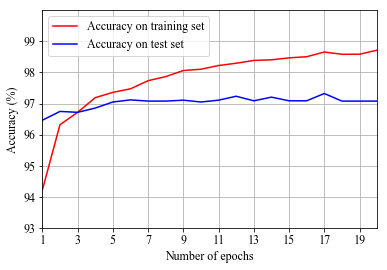

In [7]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

filename = '../LSTM-CNN code/Accuracy-History-CNN-3class.pickle'
with open(filename, 'rb') as f:
    epoch, history_acc, history_val_acc = pickle.load(f)
epoch = [i+1 for i in epoch]
history_val_acc = [i * 100 for i in history_val_acc]
history_acc = [i * 100 for i in history_acc]

maxEpoch = np.argmax(history_val_acc)
maxAcc_val = max(history_val_acc)
maxAcc = max(history_acc)

plt.figure(1)
axes = plt.gca()
x_min = epoch[0]
x_max = epoch[-1]
axes.set_xlim([x_min, x_max])
axes.yaxis.grid(True, which='major')
axes.yaxis.grid(True, which='all')
axes.xaxis.grid(True, which='major')
axes.set_ylim([round(min(history_acc), 0), 100])

#plt.scatter(epoch, history_acc, color='r')
plt.plot(epoch, history_acc, color='r', label='Accuracy on training set')
#plt.scatter(epoch, history_val_acc, color='b')
plt.plot(epoch, history_val_acc, color='b', label='Accuracy on test set')
plt.xticks(np.arange(x_min, x_max, 2))
plt.yticks(np.arange(93, 100, 1))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Train-Test Accuracy', dpi=600)
